# Airline Customer Segmentation with K-Means Clustering


* <a href="https://drive.google.com/file/d/14G4xOWK5e-QQ9S7GmBwULChNdeJZXs2U/view?usp=sharing">Dataset</a>
* Objective: to create segmentation of airline customers, and cry.

## Import Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/data/Copy of flight.csv')

df.head()

Mounted at /content/drive


,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,54993,11/2/2006,12/24/2008,Male,6,.,beijing,CN,31.0,3/31/2014,...,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
1,28065,2/19/2007,8/3/2007,Male,6,NaN,beijing,CN,42.0,3/31/2014,...,167434.0,293678,3/25/2014,7,5.194245,17,29,1.252314,415768,33
2,55106,2/1/2007,8/30/2007,Male,6,.,beijing,CN,40.0,3/31/2014,...,164982.0,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26
3,21189,8/22/2008,8/23/2008,Male,5,Los Angeles,CA,US,64.0,3/31/2014,...,125500.0,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12
4,39546,4/10/2009,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,3/31/2014,...,130702.0,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEMBER_NO          62988 non-null  int64  
 1   FFP_DATE           62988 non-null  object 
 2   FIRST_FLIGHT_DATE  62988 non-null  object 
 3   GENDER             62985 non-null  object 
 4   FFP_TIER           62988 non-null  int64  
 5   WORK_CITY          60719 non-null  object 
 6   WORK_PROVINCE      59740 non-null  object 
 7   WORK_COUNTRY       62962 non-null  object 
 8   AGE                62568 non-null  float64
 9   LOAD_TIME          62988 non-null  object 
 10  FLIGHT_COUNT       62988 non-null  int64  
 11  BP_SUM             62988 non-null  int64  
 12  SUM_YR_1           62437 non-null  float64
 13  SUM_YR_2           62850 non-null  float64
 14  SEG_KM_SUM         62988 non-null  int64  
 15  LAST_FLIGHT_DATE   62988 non-null  object 
 16  LAST_TO_END        629

* There are 8 columns with object data type (not numeric) and 15 columns with numeric data type (int & float).
* From all those columns, some columns are supposed in another data-type (e.g: `MEMBER_NO` not supposed to be `int` because it is not something calculated, and other datetime columns).
* There are around 1-3% of **missing values** in 7 columns, those columns are: `GENDER`, `WORK_CITY`, `WORK_PROVINCE`, `WORK_COUNTRY`, `SUM_YR_1`, `SUM_YR_2`, and `AGE`.

Column description.
* MEMBER_NO: ID Member
* FFP_DATE: Frequent Flyer Program Join Date
* FIRST_FLIGHT_DATE: Tanggal Penerbangan pertama
* GENDER : Jenis Kelamin
* FFP_TIER	: Tier dari Frequent Flyer Program
* WORK_CITY 	: Kota Asal
* WORK_PROVINCE : Provinsi Asal
* WORK_COUNTRY : Negara Asal
* AGE : Umur Customer
* LOAD_TIME : Tanggal data diambil
* FLIGHT_COUNT : Jumlah penerbangan Customer
* BP_SUM : Rencana Perjalanan
* SUM_YR_1 : Fare Revenue
* SUM_YR_2 : Votes Prices
* SEG_KM_SUM : Total jarak(km) penerbangan yg sudah dilakukan
* LAST_FLIGHT_DATE : Tanggal penerbangan terakhir
* LAST_TO_END  : Jarak waktu penerbangan terakhir ke pesanan penerbangan paling akhir
* AVG_INTERVAL : Rata-rata jarak waktu
* MAX_INTERVAL : Maksimal jarak waktu
* EXCHANGE_COUNT : Jumlah penukaran
* avg_discount : Rata rata discount yang didapat customer
* Points_Sum : Jumlah poin yang didapat customer
* Point_NotFlight : point yang tidak digunakan oleh members


## Data Preprocessing

Despite the example proceed the data with only 5 columns (LRFMC), for this one we are going to try different approach with consideration of all columns and then do PCA with 2 components.
* The data cleaning through all columns is needed.
* To see the segmentation of customers based on the time spent, flight counts, points, etc.



In [ ]:
# MEMBER_NO column is too unique so we will drop it

df_prep = df.drop('MEMBER_NO', axis=1)

In [ ]:
# Drop columns that are actually contain datetime ('FFP_DATE', 'FIRST_FLIGHT_DATE', 'LOAD_TIME', 'LAST_FLIGHT_DATE')

date_time = ['FFP_DATE', 'FIRST_FLIGHT_DATE', 'LOAD_TIME', 'LAST_FLIGHT_DATE']
df_prep = df_prep.drop(columns=(date_time), axis=1)

In [ ]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   GENDER           62985 non-null  object 
 1   FFP_TIER         62988 non-null  int64  
 2   WORK_CITY        60719 non-null  object 
 3   WORK_PROVINCE    59740 non-null  object 
 4   WORK_COUNTRY     62962 non-null  object 
 5   AGE              62568 non-null  float64
 6   FLIGHT_COUNT     62988 non-null  int64  
 7   BP_SUM           62988 non-null  int64  
 8   SUM_YR_1         62437 non-null  float64
 9   SUM_YR_2         62850 non-null  float64
 10  SEG_KM_SUM       62988 non-null  int64  
 11  LAST_TO_END      62988 non-null  int64  
 12  AVG_INTERVAL     62988 non-null  float64
 13  MAX_INTERVAL     62988 non-null  int64  
 14  EXCHANGE_COUNT   62988 non-null  int64  
 15  avg_discount     62988 non-null  float64
 16  Points_Sum       62988 non-null  int64  
 17  Point_NotFli

In [ ]:
df_prep.describe()

,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
count,62988.000000,62568.000000,62988.000000,62988.000000,62437.000000,62850.000000,62988.000000,62988.000000,62988.000000,62988.000000,62988.000000,62988.000000,62988.0000,62988.000000
mean,4.102162,42.476346,11.839414,10925.081254,5355.376064,5604.026014,17123.878691,176.120102,67.749788,166.033895,0.319775,0.721558,12545.7771,2.728155
std,0.373856,9.885915,14.049471,16339.486151,8109.450147,8703.364247,20960.844623,183.822223,77.517866,123.397180,1.136004,0.185427,20507.8167,7.364164
min,4.000000,6.000000,2.000000,0.000000,0.000000,0.000000,368.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
25%,4.000000,35.000000,3.000000,2518.000000,1003.000000,780.000000,4747.000000,29.000000,23.370370,79.000000,0.000000,0.611997,2775.0000,0.000000
50%,4.000000,41.000000,7.000000,5700.000000,2800.000000,2773.000000,9994.000000,108.000000,44.666667,143.000000,0.000000,0.711856,6328.5000,0.000000
75%,4.000000,48.000000,15.000000,12831.000000,6574.000000,6845.750000,21271.250000,268.000000,82.000000,228.000000,0.000000,0.809476,14302.5000,1.000000
max,6.000000,110.000000,213.000000,505308.000000,239560.000000,234188.000000,580717.000000,731.000000,728.000000,728.000000,46.000000,1.500000,985572.0000,140.000000


Most data in `EXCHANGE_COUNT` is 0, and some customers did not do any transaction yet, as per `AVG_INTERVAL` minimum value is 0.

In [ ]:
df_prep['EXCHANGE_COUNT'].value_counts()

0     54254
1      3969
2      2272
3      1066
4       591
5       309
6       186
7       106
8        71
9        38
10       36
11       18
12       14
14       11
13       11
15        9
17        5
20        4
18        4
16        3
27        3
22        2
21        1
46        1
34        1
19        1
29        1
37        1
Name: EXCHANGE_COUNT, dtype: int64

Because most values are 0, which mean even when the outliers handled, the result would be 0. So we only going to use data which contain `EXCHANGE_COUNT` > 0.

In [ ]:
df_prep = df_prep[df_prep['EXCHANGE_COUNT'] > 0]

In [ ]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8734 entries, 0 to 62984
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   GENDER           8733 non-null   object 
 1   FFP_TIER         8734 non-null   int64  
 2   WORK_CITY        8490 non-null   object 
 3   WORK_PROVINCE    8408 non-null   object 
 4   WORK_COUNTRY     8731 non-null   object 
 5   AGE              8705 non-null   float64
 6   FLIGHT_COUNT     8734 non-null   int64  
 7   BP_SUM           8734 non-null   int64  
 8   SUM_YR_1         8716 non-null   float64
 9   SUM_YR_2         8732 non-null   float64
 10  SEG_KM_SUM       8734 non-null   int64  
 11  LAST_TO_END      8734 non-null   int64  
 12  AVG_INTERVAL     8734 non-null   float64
 13  MAX_INTERVAL     8734 non-null   int64  
 14  EXCHANGE_COUNT   8734 non-null   int64  
 15  avg_discount     8734 non-null   float64
 16  Points_Sum       8734 non-null   int64  
 17  Point_NotFlig

In [ ]:
df_prep.describe()

,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
count,8734.000000,8705.000000,8734.000000,8734.000000,8716.000000,8732.000000,8734.000000,8734.000000,8734.000000,8734.000000,8734.00000,8734.000000,8734.000000,8734.000000
mean,4.344516,42.966226,27.726471,27927.111633,13290.988527,13752.320202,40203.291504,81.825395,39.024325,144.043623,2.30616,0.760797,34278.786696,8.878177
std,0.627471,9.259410,22.615303,29980.389718,14225.121597,15232.014874,34645.719603,116.256463,42.219025,92.619501,2.17402,0.181034,39243.928213,12.582327
min,4.000000,20.000000,2.000000,0.000000,0.000000,0.000000,746.000000,1.000000,0.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,4.000000,36.000000,12.000000,10362.000000,4386.500000,3942.750000,17280.250000,11.000000,17.189511,80.000000,1.00000,0.659096,12687.000000,2.000000
50%,4.000000,41.000000,21.000000,19367.500000,9449.000000,9200.000000,30858.500000,33.000000,27.787138,122.000000,2.00000,0.735445,23138.000000,3.000000
75%,5.000000,48.000000,37.000000,35425.250000,17384.000000,18290.750000,52922.500000,104.000000,45.266667,181.000000,3.00000,0.821218,41676.500000,10.000000
max,6.000000,110.000000,210.000000,505308.000000,239560.000000,234188.000000,580717.000000,725.000000,652.000000,693.000000,46.00000,1.500000,985572.000000,140.000000


Now the `EXCHANGE_COUNT` is more varied.

### Duplicate

In [ ]:
df_prep.duplicated().sum()

0

### Null values

In [ ]:
df_prep.isnull().sum()

GENDER               1
FFP_TIER             0
WORK_CITY          244
WORK_PROVINCE      326
WORK_COUNTRY         3
AGE                 29
FLIGHT_COUNT         0
BP_SUM               0
SUM_YR_1            18
SUM_YR_2             2
SEG_KM_SUM           0
LAST_TO_END          0
AVG_INTERVAL         0
MAX_INTERVAL         0
EXCHANGE_COUNT       0
avg_discount         0
Points_Sum           0
Point_NotFlight      0
dtype: int64

First, because the null-values are still around 1-3%, we could just fill null-values of numeric columns with mean values. So we do not lose any other information in the same row.

In [ ]:
df_prep[['SUM_YR_1', 'SUM_YR_2', 'AGE']] = df_prep[['SUM_YR_1', 'SUM_YR_2', 'AGE']].fillna(df_prep[['SUM_YR_1', 'SUM_YR_2', 'AGE']].mean())

In [ ]:
df_prep.isnull().sum()

GENDER               1
FFP_TIER             0
WORK_CITY          244
WORK_PROVINCE      326
WORK_COUNTRY         3
AGE                  0
FLIGHT_COUNT         0
BP_SUM               0
SUM_YR_1             0
SUM_YR_2             0
SEG_KM_SUM           0
LAST_TO_END          0
AVG_INTERVAL         0
MAX_INTERVAL         0
EXCHANGE_COUNT       0
avg_discount         0
Points_Sum           0
Point_NotFlight      0
dtype: int64

Because the only columns left are those with object-data-type, and it is only around 1-3% which means other information in that row still needed for modelling. <br>
Let's create a new values to fill the null-values in object-data-type columns.

In [ ]:
df_prep[['GENDER', 'WORK_CITY', 'WORK_PROVINCE', 'WORK_COUNTRY']] = df_prep[['GENDER', 'WORK_CITY', 'WORK_PROVINCE', 'WORK_COUNTRY']].fillna('Not Applicable')

In [ ]:
df_prep.isnull().sum()

GENDER             0
FFP_TIER           0
WORK_CITY          0
WORK_PROVINCE      0
WORK_COUNTRY       0
AGE                0
FLIGHT_COUNT       0
BP_SUM             0
SUM_YR_1           0
SUM_YR_2           0
SEG_KM_SUM         0
LAST_TO_END        0
AVG_INTERVAL       0
MAX_INTERVAL       0
EXCHANGE_COUNT     0
avg_discount       0
Points_Sum         0
Point_NotFlight    0
dtype: int64

In [ ]:
df_prep[df_prep['WORK_COUNTRY'].isnull()]

,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight


There is no more null-values detected. Furthermore, the anomalies in categorical columns are not handled because it is not considered in clustering.

### Outliers

In [ ]:
df_num = df_prep.select_dtypes(include='number')

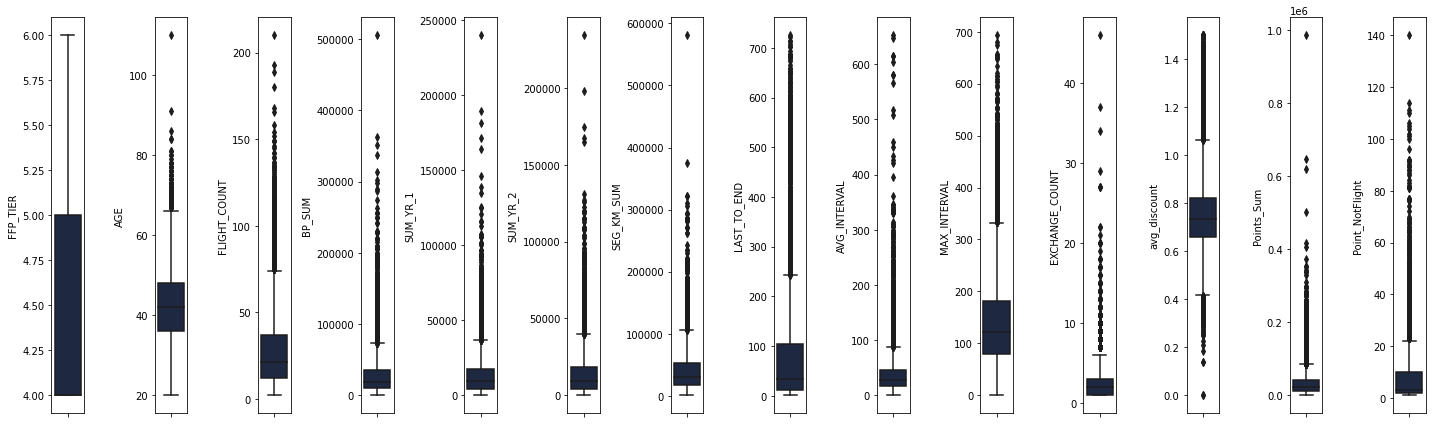

In [ ]:
# checking outliers from the columns
plt.figure(figsize=(20,6))

# plotting
features = list(df_num)
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=df_num[features[i]], color='#182747')
    plt.tight_layout()

In [ ]:
# change outliers values to upper/bottom skew

def chg_out(data):
    for col in data.columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        if (((data[col].dtype)=='float64') | ((data[col].dtype)=='int64')):
            data[col][data[col] <= (Q1-(1.5*IQR))] = Q1
            data[col][data[col] >= (Q3+(1.5*IQR))] = Q3
        else:
            data[col]=data[col]
    return data

final_df = chg_out(df_num)

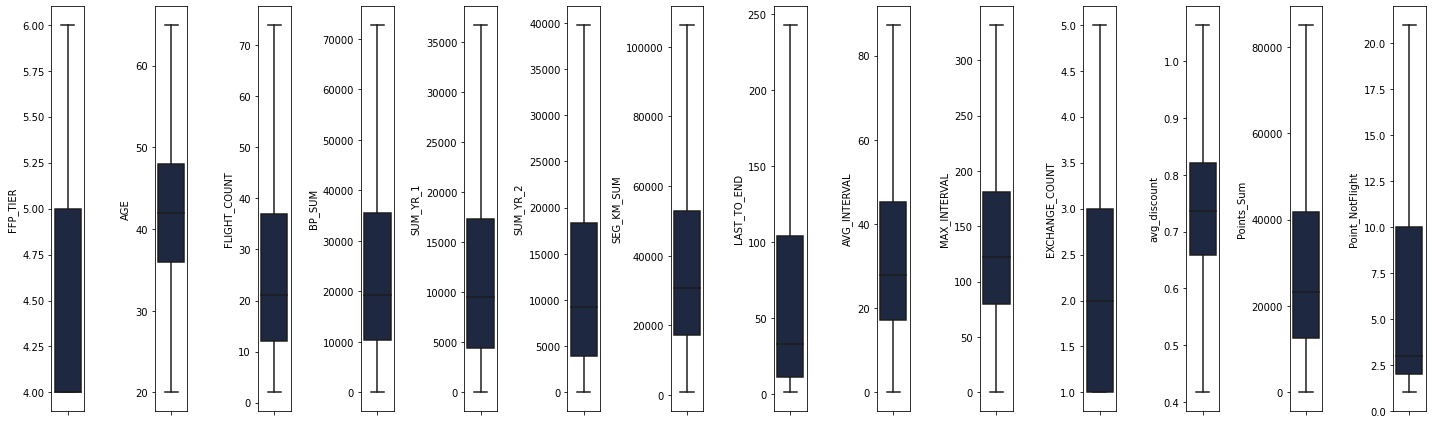

In [ ]:
# checking outliers from the columns
plt.figure(figsize=(20,6))

# plotting
features = list(final_df)
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=df_num[features[i]], color='#182747')
    plt.tight_layout()

In [ ]:
final_df.describe()

,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
count,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000
mean,4.344516,42.501720,24.963476,23071.721605,11126.539992,11443.761466,35699.246966,56.540760,31.456351,132.408175,1.969430,0.736472,27381.449336,5.310740
std,0.627471,8.335451,16.457828,16003.600210,8296.940915,9182.389108,23199.224220,57.120813,17.984265,67.517417,1.106844,0.113331,18524.886839,4.657989
min,4.000000,20.000000,2.000000,0.000000,0.000000,0.000000,746.000000,1.000000,0.000000,0.000000,1.000000,0.416875,0.000000,1.000000
25%,4.000000,36.000000,12.000000,10362.000000,4402.000000,3944.250000,17280.250000,11.000000,17.189511,80.000000,1.000000,0.659096,12687.000000,2.000000
50%,4.000000,42.000000,21.000000,19367.500000,9473.500000,9204.500000,30858.500000,33.000000,27.787138,122.000000,2.000000,0.735445,23138.000000,3.000000
75%,5.000000,48.000000,37.000000,35421.687500,17324.062500,18286.500000,52920.625000,104.000000,45.266667,181.000000,3.000000,0.821217,41673.125000,10.000000
max,6.000000,65.000000,74.000000,72774.000000,36691.000000,39777.000000,106316.000000,243.000000,87.333333,332.000000,5.000000,1.064091,85123.000000,21.000000


## Scaling

In [ ]:
sc = StandardScaler()
data_std = sc.fit_transform(final_df)

In [ ]:
df_data_std = pd.DataFrame(data=data_std, columns=list(final_df))

## Clustering

### Elbow Methods

Text(0, 0.5, 'WCSS')

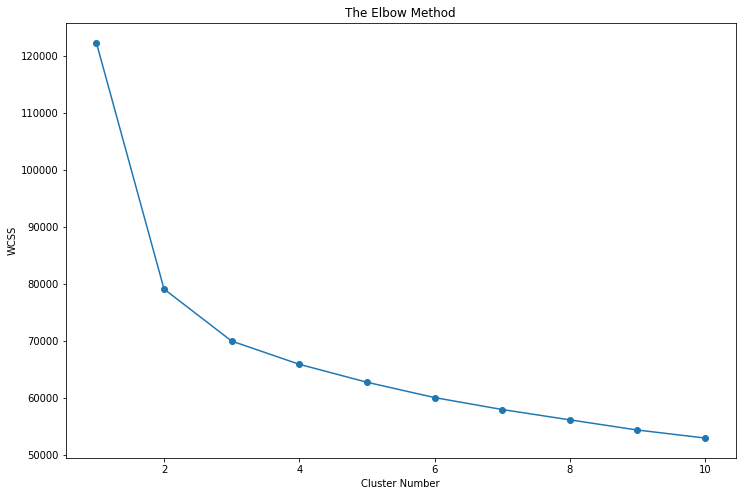

In [ ]:
wcss = []
for x in range (1,11):
  kmeans = KMeans(n_clusters = x, init='k-means++', random_state=42)
  kmeans.fit(data_std)
  wcss.append(kmeans.inertia_)

plt.figure(figsize=(12,8))
plt.plot(range(1,11), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Cluster Number')
plt.ylabel('WCSS')

Based on `elbow methods`, the cluster number could be 3-4 clusters.

### Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_score

range_n_clusters = list(range(2,11))
print(range_n_clusters)

[2, 3, 4, 5, 6, 7, 8, 9, 10]


In [ ]:
arr_silhouette_score_euclidean = []
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i).fit(df_data_std)
    preds = kmeans.predict(df_data_std)

    score_euclidean = silhouette_score(df_data_std, preds, metric='euclidean')
    arr_silhouette_score_euclidean.append(score_euclidean)

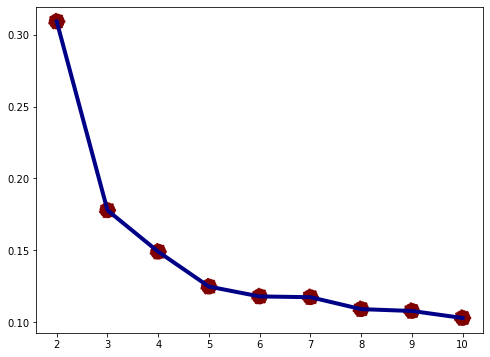

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(x=range(2,11), y=arr_silhouette_score_euclidean, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2,11), y=arr_silhouette_score_euclidean, s=300, color='#800000',  linestyle='--')

Based on `silhouette score`, number of cluster is 2 (the silhouette score is closer to 1). <br>
Because both provide different numbers, let's pick the middle one. <br>
We are going to make **3 clusters**.

### KMeans

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(data_std)

In [ ]:
df_data_std['clusters'] = kmeans.labels_
final_df['clusters'] = kmeans.labels_

In [ ]:
final_df.head(3)

,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight,clusters
0,6,31.0,37,35425.25,17325.75,18288.0,52922.5,1,3.483254,18,3,0.961639,41676.5,10,1
1,6,42.0,37,35425.25,17325.75,18288.0,52922.5,7,5.194245,17,3,0.821218,41676.5,10,1
2,6,40.0,37,35425.25,17325.75,18288.0,52922.5,11,5.298507,18,3,0.821218,41676.5,10,1


##PCA

In [ ]:
pca = PCA(n_components=2)

pca.fit(data_std)
pcs = pca.transform(data_std)

data_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
data_pca['clusters'] = final_df['clusters']
data_pca.head()

,PC 1,PC 2,clusters
0,3.748283,1.176458,1.0
1,3.611002,0.500966,1.0
2,3.585108,0.651707,1.0
3,2.153268,-0.528429,1.0
4,3.677481,-0.030606,1.0


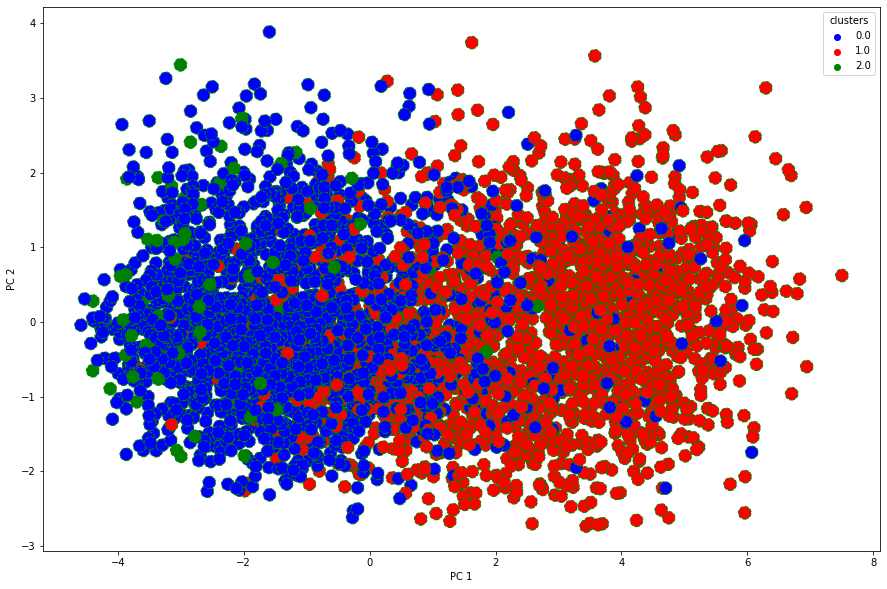

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

sns.scatterplot(
    x="PC 1", y="PC 2",
    hue="clusters",
    edgecolor='green',
    linestyle='--',
    data=data_pca,
    palette=['blue','red','green'],
    s=160,
    ax=ax)

It is actually kind of chaos... But we could see `Cluster 0` the leftest side, `Cluster 2` behind both cluster but slightly to the left, and `Cluster 1` on the rightest side. All the clusters are still overlapping with each others.

In [ ]:
pd.set_option("display.max_columns", None)
display(final_df.groupby('clusters').agg(['mean','median']))

FFP_TIER               AGE        FLIGHT_COUNT               BP_SUM  \
              mean median       mean median         mean median          mean   
clusters                                                                        
0         4.175399    4.0  42.187991   41.0    26.755939   26.0  24292.790840   
1         5.115621    5.0  43.749770   43.0    46.134969   44.0  44390.716022   
2         4.029927    4.0  42.027262   41.0    10.742518   11.0   9258.256070   

                       SUM_YR_1               SUM_YR_2             SEG_KM_SUM  \
           median          mean   median          mean   median          mean   
clusters                                                                        
0         23201.0  11899.031620  11436.0  11804.158802  11410.0  38383.620404   
1         41109.0  20343.645941  18544.0  23116.463426  21392.0  65281.204578   
2          8919.5   4942.205074   4287.5   4147.895720   3535.5  15672.920666   

                  LAST_TO_END        AVG_INTERVAL            MAX_INTERVAL  \
           median        mean median         mean     median         mean   
clusters                                                                    
0         36663.0   45.908884   28.0    25.729468  24.413793   121.007810   
1         61517.0   19.171779   10.0    14.070045  13.113208    77.683813   
2         14969.0   88.120836   95.0    46.826282  45.266667   175.037832   

                EXCHANGE_COUNT        avg_discount              Points_Sum  \
         median           mean median         mean    median          mean   
clusters                                                                     
0         113.0       1.960625    2.0     0.738895  0.733939  28116.021640   
1          70.0       2.773006    3.0     0.779052  0.779879  51118.550967   
2         181.0       1.496330    1.0     0.708895  0.705291  12543.431536   

                  Point_NotFlight         
           median            mean median  
clusters                                  
0         26072.0        4.882851    3.0  
1         46070.0        8.026899    8.0  
2         11091.0        4.057030    2.0

Total per cluster:

In [ ]:
final_df['clusters'].value_counts()

2    3542
0    3073
1    2119
Name: clusters, dtype: int64

### Conclusion

Because, it turns out, some of the features can not be described into an insight. So, we select 6 features that could be concluded:

* **Regular Customer & Medium Spender (Cluster 0, total: 35,2%)**: book domestic and/or international flight (once a month) and might use points for discount. Could be someone who needs to fly for business meeting or visit family.<br>
median of booked flights = 26, <br>
median of km of flights = 38.383 km, <br>
median of interval between flights = 28, <br>
median score of exchange = 2 times. <br>
median score of total points = 26.072, <br>
average of discount = 73%.

* **Loyal Customer & High Spender (Cluster 1, total: 24,3%)**: book domestic but mostly international flight frequently (once per 10 days) and would use points for discount. Could be a business person who needs to fly to see their clients.<br>
median of booked flights = 44, <br>
median of km of flights = 46.070 km, <br>
median of interval between flights = 10, <br>
median score of exchange = 3 times. <br>
median score of total points = 112.843, <br>
average of discount = 77%.

* **Occasional Customer (Cluster 1, total: 40,5%)**: only book domestic flight if necessary (once per 3 months), even without exchanging points.  Maybe for holiday only. <br>
median of booked flights = 11, <br>
median of km of flights = 15.672 km, <br>
median of interval between flights = 95, <br>
median score of exchange = 1 times. <br>
median score of total points = 11.091, <br>
average of discount = 70%.
<br>

The `loyal customer`'s number is still lower than the other type of customers. The airlines could push a loyalty program for those customers in `occasional customer`, BUT because it is an airline company which flight are not basic needs for some people, maybe the company needs to extend the length of the program so other customers who flight occasionally could use it.

###Conclusion (without handling outliers)

Because, it turns out, some of the features can not be described into an insight. So, we select 4 features that could be concluded:

* **Loyal Customer & High Spender (Cluster 0, total: 7%)**: book flight frequently and use points. <br>
median of booked flights = 77, <br>
median of km of flights = 115.113,5 km, <br>
median of interval between flights = 7, <br>
median score of total points = 112.843, <br>
median score of exchange = 5 times.
* **Occasional Customer (Cluster 1, total: 58,6%)**: only book flight if necessary, even without exchanging points. <br>
median of booked flights = 14, <br>
median of km of flights = 19.541 km, <br>
median of interval between flights = 73, <br>
median score of total points = 14.283, <br>
median score of exchange = 1 times.
* **Regular Customer & Medium Spender (Cluster 2, total: 34,4%)**: book flight oftenly and would use points. <br>
median of booked flights = 38, <br>
median of km of flights = 53.558 km, <br>
median of interval between flights = 14, <br>
median score of total points = 40.899, <br>
median score of exchange = 2 times.

**Conclusion**: The airlines still have low number of loyal customer than regular and occasional customer. There is no data of revenue from the airlines, so we do not know how it affects the revenue. <br>
**Suggestion**: Maybe another program for loyal customers to stay loyal to the airlines (e.g: reward program, silver/platinum member). It could also affect the interest of non-customer or frequent ones to also fly more with the airlines. **BUT** there are also external factors, like jobs and economic situation of the customers that are out of company's control.

## Further Analysis

* The distribution of each clusters based on their gender, city, province, or country.
* From the distribution, the airlines could find which city to focus on and what kind of promotion to apply.
* The relation between customer segmentation and airlines' revenue (could be timeseries).

## Features reduction before clustering (Trial n Error)

What if we only keep the 6 columns that could easily be described into insight before clustering? And, what if the number of clusters are 2 (silhouette score)?

In [ ]:
df_fin_r = df_prep[['FLIGHT_COUNT', 'SEG_KM_SUM','LAST_TO_END', 'EXCHANGE_COUNT', 'avg_discount', 'Points_Sum']]

In [ ]:
sc = StandardScaler()
data_std_r = sc.fit_transform(df_fin_r)

###Elbow Methods

Text(0, 0.5, 'WCSS')

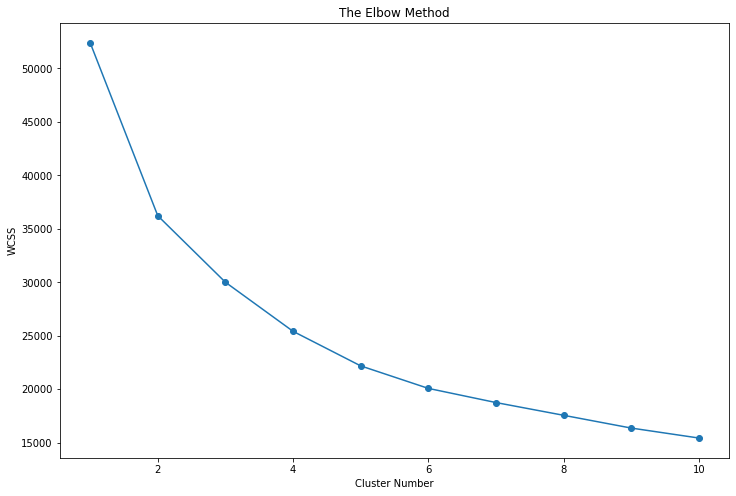

In [ ]:
wcss = []
for x in range (1,11):
  kmeans = KMeans(n_clusters = x, init='k-means++', random_state=42)
  kmeans.fit(data_std_r)
  wcss.append(kmeans.inertia_)

plt.figure(figsize=(12,8))
plt.plot(range(1,11), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Cluster Number')
plt.ylabel('WCSS')

It still has the same angle with before, but we are going to use the number '2' as it has the deepest drop.

###KMeans

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(data_std_r)

In [ ]:
df_data_stdr = pd.DataFrame(data=data_std_r, columns=list(df_fin_r))

In [ ]:
df_data_stdr['clusters'] = kmeans.labels_
df_fin_r['clusters'] = kmeans.labels_

In [ ]:
df_fin_r.head(3)

,FLIGHT_COUNT,SEG_KM_SUM,LAST_TO_END,EXCHANGE_COUNT,avg_discount,Points_Sum,clusters
0,210,580717,1,34,0.961639,619760,1
1,140,293678,7,29,1.252314,415768,1
2,135,283712,11,20,1.254676,406361,1


###PCA

In [ ]:
pca = PCA(n_components=2)

pca.fit(data_std_r)
pcs_r = pca.transform(data_std_r)

data_pca_r = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
data_pca_r['clusters'] = df_fin_r['clusters']
data_pca_r.head()

,PC 1,PC 2,clusters
0,3.748283,1.176458,1.0
1,3.611002,0.500966,1.0
2,3.585108,0.651707,1.0
3,2.153268,-0.528429,1.0
4,3.677481,-0.030606,1.0


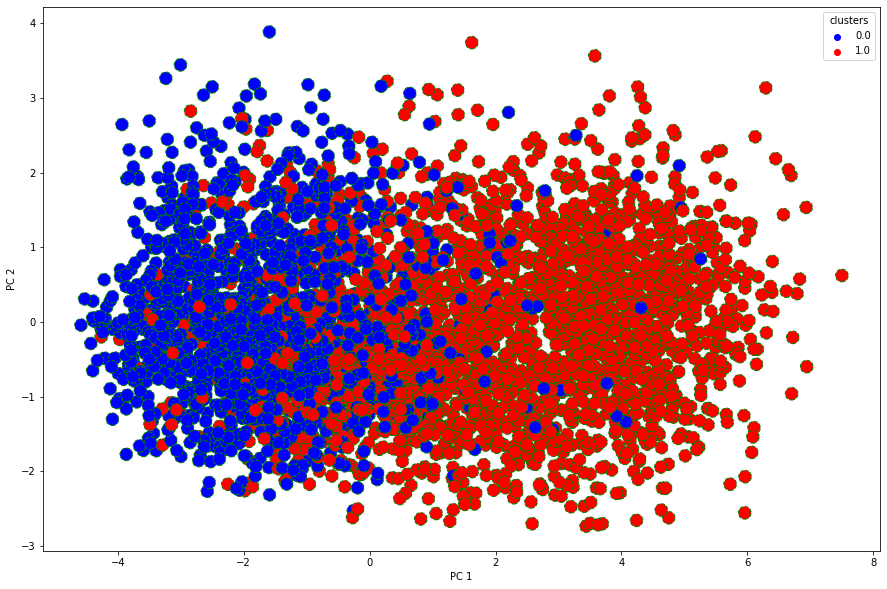

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

sns.scatterplot(
    x="PC 1", y="PC 2",
    hue="clusters",
    edgecolor='green',
    linestyle='--',
    data=data_pca_r,
    palette=['blue','red'],
    s=160,
    ax=ax)

`Cluster 0` is on the left-side and `Cluster 1` is on the right-side.

In [ ]:
pd.set_option("display.max_columns", None)
display(df_fin_r.groupby('clusters').agg(['mean','median']))

FLIGHT_COUNT           SEG_KM_SUM          LAST_TO_END         \
                 mean median          mean   median        mean median   
clusters                                                                 
0           16.715428   16.0  23983.236588  22169.5  107.618627   59.0   
1           51.916911   47.0  75837.540996  65989.5   25.159590   12.0   

         EXCHANGE_COUNT        avg_discount              Points_Sum           
                   mean median         mean    median          mean   median  
clusters                                                                      
0              1.665112    1.0     0.724000  0.716865  18068.734255  16193.0  
1              3.714495    3.0     0.841639  0.774226  69891.061493  54275.5

Total per cluster:

In [ ]:
df_fin_r['clusters'].value_counts()

0    6002
1    2732
Name: clusters, dtype: int64

###Conclusion

* **Regular Customer (Cluster 0, total: 68,7%)**: book domestic and/or international flight (once in 2 months) and might use points for discount. Could be someone who needs to fly for business meeting or visit family. <br>
median of booked flights = 16, <br>
median of km of flights = 22.169 km, <br>
median of interval between flights = 59, <br>
median score of exchange = 1 time, <br>
average of discount = 71%, <br>
median score of total points = 16.193, <br>


* **Loyal Customer (Cluster 1, total: 21.3%)**: book domestic but mostly international flight frequently (once per 12 days) and would use points for discount. Could be a business person who needs to fly to see their clients. <br>
median of booked flights = 47, <br>
median of km of flights = 65.989 km, <br>
median of interval between flights = 12, <br>
median score of exchange = 3 times, <br>
average of discount = 77%, <br>
median score of total points = 54.275.

There is some changes in median values that make  both the `regular customer` and the `loyal customer` more obvious and segmented. Though the total of `loyal customer` is getting lower while the regular one getting higher... (this maybe because other features not calculated).

###Conclusion (without Handling Outliers)

* **Regular Customer & Medium Spender (Cluster 0, total: 54,9%)**: book flight oftenly and might use points. <br>
median of booked flights = 26, <br>
median of km of flights = 36.406 km, <br>
median of interval between flights = 18, <br>
median score of total points = 26.163, <br>
median score of exchange = 2 times.

* **Occasional Customer (Cluster 1, total: 32.9%)**: only book flight if necessary, even without exchanging points. <br>
median of booked flights = 11, <br>
median of km of flights = 16.070 km, <br>
median of interval between flights = 104, <br>
median score of total points = 12.345, <br>
median score of exchange = 1 time.

* **Loyal Customer & High Spender (Cluster 2, total: 12.2%)**: book flight frequently and use points. <br>
median of booked flights = 67, <br>
median of km of flights = 96.407 km, <br>
median of interval between flights = 8, <br>
median score of total points = 87.630, <br>
median score of exchange = 4 times.

There is some changes in median value that make the *occasional customer* more obvious, but the *loyal customer* value is lower than before. But the total number of each clusters is more distributed.